# Deteksi Outlier dengan K-Nearest Neighbors (KNN) dalam Data Understanding

## Mengapa KNN Bisa Digunakan untuk Deteksi Outlier?

KNN merupakan algoritma berbasis jarak yang memanfaatkan hubungan antar data dalam ruang berdimensi. Dalam deteksi outlier, konsep utama yang digunakan adalah kedekatan antar data dan kepadatannya.

Bayangkan dataset sebagai sekumpulan titik di peta:
- Titik yang berada jauh dari kelompok lain dapat dianggap sebagai outlier.
- Titik yang memiliki sedikit tetangga di sekitarnya juga bisa dicurigai sebagai outlier.

Dengan kata lain, jika suatu data memiliki tetangga yang jauh atau sangat sedikit, maka kemungkinan besar data tersebut adalah outlier.

## Langkah-Langkah Deteksi Outlier dengan KNN

a. Menghitung Jarak Antar Titik

- Kita bisa menggunakan metrik jarak seperti Euclidean Distance atau Manhattan Distance untuk melihat kedekatan antar titik.
- Jika titik tertentu memiliki jarak yang jauh dibandingkan dengan data lainnya, maka ia berpotensi menjadi outlier.

b. Menentukan K (Jumlah Tetangga Terdekat)

- Kecilkan K, dan kita akan lebih sensitif terhadap noise (kesalahan kecil bisa dianggap outlier).
- Besarkan K, dan model akan lebih toleran terhadap outlier tapi bisa kehilangan sensitivitasnya.

c. Menilai Kejanggalan Data (Outlier Score)

Beberapa cara untuk menilai apakah suatu titik adalah outlier:
- Average Distance to K Nearest Neighbors
→ Mengukur jarak rata-rata suatu titik ke tetangga terdekatnya. Jika terlalu besar, titik tersebut dicurigai sebagai outlier.
- Local Outlier Factor (LOF)
→ Membandingkan kepadatan suatu titik dengan kepadatan tetangganya. Jika titik memiliki kepadatan rendah, maka lebih mungkin menjadi outlier.
- K-Distance Neighborhood
→ Menentukan jumlah tetangga dalam radius tertentu. Jika jumlahnya terlalu sedikit, kemungkinan besar itu adalah outlier

## Kesimpulan
KNN bukan hanya digunakan untuk klasifikasi atau regresi, tetapi juga alat yang sangat kuat dalam memahami struktur data, terutama dalam mendeteksi anomali atau outlier. Dengan memahami distribusi jarak antar titik, kita dapat menyingkirkan data yang mencurigakan dan memastikan analisis lebih akurat.

In [1]:
%pip install pymysql
%pip install psycopg2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.5 MB/s eta 0:00:00


Kode di atas berfungsi untuk menginstal dua pustaka Python, yaitu "pymysql" dan "psycopg2", yang digunakan sebagai konektor ke database. "pymysql" memungkinkan Python berkomunikasi dengan **MySQL atau MariaDB** menggunakan protokol MySQL, sedangkan "psycopg2" digunakan untuk menghubungkan Python dengan **PostgreSQL**, menyediakan antarmuka yang optimal untuk menjalankan query SQL serta berinteraksi dengan database tersebut.

Kedua perintah ini menggunakan **magic command** (%pip), yang biasanya digunakan dalam **Jupyter Notebook** untuk memastikan instalasi pustaka dilakukan dalam lingkungan (kernel) yang sedang aktif, sehingga dapat langsung digunakan dalam sesi notebook yang berjalan.

 id           class  petal_length  petal_width  sepal length  sepal width  knn_distance  outlier_knn
  1     Iris-setosa           1.4          0.2           5.1          3.5      0.141421        False
  2     Iris-setosa          14.0          2.0          40.9         30.0     43.517123         True
  3     Iris-setosa           1.3          0.2           4.7          3.2      0.264575        False
  4     Iris-setosa           1.5          0.2           4.6          3.1      0.244949        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      0.223607        False
  6     Iris-setosa           1.7          0.4           5.4          3.9      0.374166        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.316228        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.200000        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      0.346410    

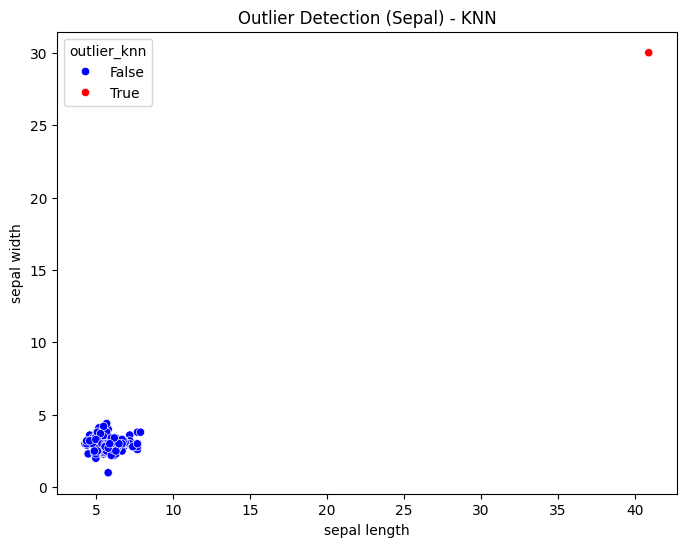

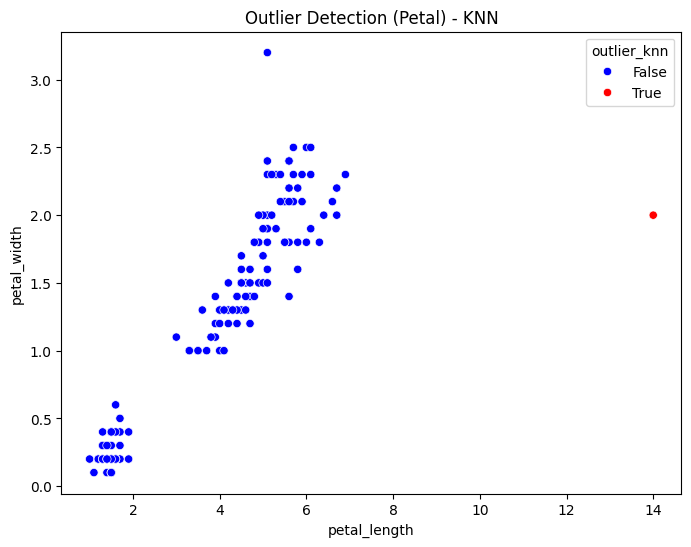

In [4]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-382999bb-posgresqlpendataa.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_AwzON_kzF3kYXNu_CrZ",
        database="defaultdb",
        port=11188
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM nabila.postgres;")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-9b686fb-pendataa.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_ZuFdVS1OQkmHx4P1Wtp",
        database="defaultdb",
        port=22825
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal length", "sepal width"]
data_values = df_merged[feature_columns].values

# KNN Outlier Detection
def knn_outlier_detection(data, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=5)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Cetak hasil
df_result = df_merged[["id", "class", "petal_length", "petal_width", "sepal length", "sepal width", "knn_distance", "outlier_knn"]]
print(df_result.to_string(index=False))
num_outliers = df_merged["outlier_knn"].sum()
print(f"\nJumlah outlier: {num_outliers}")

# Cetak data outlier
outliers = df_merged[df_merged["outlier_knn"]]
print("\nData Outlier:")
print(outliers.to_string(index=False))

# Visualisasi outlier berdasarkan K-NN
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["sepal length"], y=df_merged["sepal width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Sepal) - KNN")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["petal_length"], y=df_merged["petal_width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Petal) - KNN")
plt.show()

Kode diatas ini bertujuan untuk mendeteksi outlier menggunakan metode K-Nearest Neighbors (KNN) pada data yang diambil dari dua database berbeda, yaitu PostgreSQL dan MySQL. Prosesnya dimulai dengan mengambil data dari kedua database, lalu menggabungkannya berdasarkan kolom 'id' dan 'class'. Setelah data terintegrasi, kode ini mengekstrak fitur numerik yang relevan, seperti panjang dan lebar sepal serta petal, yang kemudian digunakan untuk analisis lebih lanjut

**Metode KNN** dalam deteksi outlier bekerja dengan mengukur kedekatan antara satu titik data dengan titik-titik lain dalam ruang fitur. Fungsi (knn_outlier_detection) yang digunakan dalam kode ini menerapkan algoritma KNN untuk menentukan jarak antara setiap titik data dengan lima tetangga terdekat (k = 5). Dari lima tetangga tersebut, jarak terjauh digunakan sebagai skor jarak untuk setiap titik. Semakin besar nilai skor ini, semakin besar kemungkinan data tersebut merupakan outlier.

Agar bisa menentukan apakah suatu titik adalah outlier atau bukan, kode ini menetapkan ambang batas (threshold) berdasarkan rata-rata skor jarak ditambah dua kali standar deviasi. Jika skor jarak suatu titik melebihi threshold tersebut, maka titik tersebut diklasifikasikan sebagai outlier.

Hasil deteksi ini ditambahkan dalam kolom baru yang menunjukkan status outlier (True/False) untuk setiap data. Selain itu, kode ini juga menampilkan hasil deteksi dalam bentuk scatter plot, di mana data outlier ditandai dengan warna merah, sementara data lainnya ditampilkan dalam warna biru. Sebagai tambahan, kode ini juga mencetak jumlah outlier yang ditemukan serta menampilkan detail titik-titik yang teridentifikasi sebagai outlier